# Construção do Classificador de Gênero Musical
---

Utilizando apenas letras, classificar automaticamente músicas dentro dos gêneros 'Bossa Nova', 'Funk', 'Gospel' e 'Sertanejo'.


## Bibliotecas e configurações básicas

In [1]:
import numpy as np
import pandas as pd
import itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
#nltk.download('rslp')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import pickle

## Carregando dados
___
Preparados (estruturados) previamente em data_analysis.ipynb

In [2]:
df = pd.read_csv('../input/dataset_.csv')
df.head(10)

,lyric,genre
0,"acredite, é hora de vencer essa força vem de...",gospel
1,dime donde ha quedado todo lo que nos juramo...,bossa_nova
2,ela tem um jeitinho como ninguém que ninguém...,bossa_nova
3,"um homem, um tanque, uma cama esta era a cen...",gospel
4,putaria do carai as novinha tá demais no bai...,funk
5,comento com as amigas que o dj é bom demais ...,funk
6,"mulher, você tem uma missão você é especial ...",gospel
7,"é delano, tá ligado é delano, tá ligado é de...",funk
8,às vezes acho que devia te dizer mais vezes ...,sertanejo
9,"pai, estou aqui, olha para mim desesperado p...",gospel


## Funções básicas NLP
---
Funções e recursos como Tokenizers e Stopwords (EN e pt-BR)

In [3]:
# Estruturando stop words
with open('../resources/stopwords.txt', 'r', encoding = 'utf-8') as infile:
    stopwords = infile.read().splitlines()
# print('stop words %s ...' %stopwords[:5])

# Extrair tokens (termos, palavras) das letras
def tokenizer(text):
    source = text.lower()               # Texto para minusculo
    source = nltk.word_tokenize(source) # Extrair tokens (termos) do texto
    #source = stemming(source)           # Extrair radical dos tokens
    return source

# # Capturar radical das palavras
# def stemming(words):
#     source = []
#     stemmer = nltk.stem.RSLPStemmer()
#     for word in words:
#         source.append(stemmer.stem(word))   
#     return source

## Preparando os dados para treinamento do modelo
---

Primeiro, para a representação do espaço dimensional, se utilizará o conceito de Bag of Words, onde cada letra de música passará por um processo de 'vetorização', onde as dimensões deste vetor será cada termo presente no documento. Para atribuir valores a cada dimeensão deste vetor resultante, irá ser adotada a métrica de frequência de termos TFIDF (conforme explicado no notebook 'data_analysis').

Será criado um objeto 'vetorizador', apoiado a função <i>TfidfVectorizer</i> (presente em sklearn.feature_extraction.text), para calcular o vetor TFIDF para cada letra de música presente no dataset:

In [4]:
# Term Frequency Inverse Document Freq.(TF - Normalize Vectors, IDF: Penalize Frequent Words)
from sklearn.feature_extraction.text import TfidfVectorizer

# Objeto vetorizador
vectorizer = TfidfVectorizer(
                encoding   = 'utf-8',
                stop_words = stopwords,
                tokenizer  = tokenizer,
                min_df = 3,
                max_df = 0.6,
                sublinear_tf = True,
                ngram_range=(1, 2)
            ).fit(df['lyric'].values)

# Tabluando dataset
X = vectorizer.transform(df['lyric'].values) # Transforming
y = df['genre'].values

In [5]:
# Salvando o vectorizer (webapp)
with open('../resources/vectorizer.pkl', 'wb') as outfile:
    pickle.dump(vectorizer, outfile)

As configurações do vetorizador seguiram como:
* <b>encoding = 'utf-8'</b> (definimos o enconding para lidar com caracteres especiais, uma vez que são músicas brasileiras escritas em portuguêss, em geral);
* <b>stop_words = stopwords</b> (utilizaremos o arquivo 'stopwords' para eliminar as palavras pouco informativas - eg. 'a', 'e', 'de', etc.);
* <b>tokenizer = tokenizer</b> (definimos uma função que será responsável por 'quebrar' a letra de música em várias palavras; a vantagem de definir uma função é que podemos fazer alguns tratamentos no momento ANTES de calcular o TFIDF como normalizar as palavras (colocar todas em minúsculas, por exemplo); 
* <b>min_df = 3</b> (é o numéro mínimo de documentos que um termo deve ser citado para estar presente no vetor resultante; caso contrário o consideraremos como uma 'stopword', pois termos populares não são muito úteis para o modelo);
* <b>max_df = 0.6</b> (ignoraremos termos que aparecem em mais de 60% dos documentos);
* <b>sublinear_tf = True</b> (utilizamos a forma logarítma da frequência calculada - podenrando assim na mesma escala documentos com tamanhos diferentes);
* <b>ngram_range = (1, 2)</b> (iremos considerar palavras isoladas e também bi-gramas, ou seja, conjunto de 2 palavras em sequência na modelagem de TFIDF).

Por fim, com os dados preparados, dividiremos inicialmente o conjunto de dados entre treinamento e teste/validação. Esta divisão, em conjunto com outras estratégias (como a validação cruzada), permite avaliar o modelo calibrado diante de dados os quais o mesmo 'não conhece', viabilizando mensurarmos o viés e a variância do modelo diante de uma métrica de avaliação em tempo de treinamento e teste, medidas as quais mostram se o modelo está com overfitting (sobreajuste) ou underfitting (subajuste).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,  random_state = 3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400, 28315) (2400,)
(800, 28315) (800,)


In [7]:
# Exportando dados
with open('../input/X_train.dat', 'wb') as outfile:
    pickle.dump(X_train, outfile, pickle.HIGHEST_PROTOCOL)
with open('../input/y_train.dat', 'wb') as outfile:
    pickle.dump(y_train, outfile, pickle.HIGHEST_PROTOCOL)
    
with open('../input/X_test.dat', 'wb') as outfile:
    pickle.dump(X_test, outfile, pickle.HIGHEST_PROTOCOL)
with open('../input/y_test.dat', 'wb') as outfile:
    pickle.dump(y_test, outfile, pickle.HIGHEST_PROTOCOL)

## Classificador (Modelo ML)

### Naive Bayes (Multinomial)
---

Conforme discutido brevemete, o modelo de ML mais natural para este domínio de problema é o NaÏve-Bayes (NB). Tal escolha se justifica pois, além de sua simplicidade de implementação e eficiência de operação, sua única suposição sobre os dados é a independência entre todos os atributos e usa o teorema de Bayes para estimar a probabilidade de que as letras de uma música pertençam a uma determinada classe, usando suas probabilidades anteriores. 

O modelo NB é comumente usado em problemas de mineração de texto, como a classificação de spam em e-mail, por exemplo, o que viabiliza adotarmos esta abordagem como baseline de nossa solução.

Em tempo, como o NB é um modelo probabilístico, este sofre com o caso de um termo não estar presente no corpus, resultando em <i>P(g | t) = 0</i>. Portanto, será considerado termo <i>alpha</i> como fator de alisamento de cada atributo resultante no vetor TFIDF. 

In [8]:
# Classificador: NaiveBayes (Multinomial with TFid)
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=.01).fit(X_train, y_train)

### Avaliando o classificador

In [9]:
# Avaliacao do modelo
y_pred = clf.predict(X_test)

# Acurácia do modelo
print( 'Acurácia do classificador: %.2f%%' % (metrics.accuracy_score(y_test, y_pred)*100) )

Acurácia do classificador: 90.38%


<b>Nosso modelo NB atingiu uma acurácia de mais de 90% no conjunto de testes!!!</b> 

Poderíamos seguir realizando o 'tuning' dos hiperparâmetros - tanto do vetorizador quanto do modelo - a fim de melhorar a acurácia. Por exemplo, avaliar se realmente as 'stopwords' não estão descartando termos que podem ser preditivos ([aqui há uma discussão sobre isso](https://stackoverflow.com/questions/16927494/how-to-select-stop-words-using-tf-idf-non-english-corpus)), verificar os demais parâmetros do <i>TfidfVectorizer</i> com GridSearch (avaliar um espaço discreto de opções de ajustes destes parâmetros) ou buscar um melhor ajuste do valor de alpha no modelo MultinomialNB. Mas antes de prosseguir qualquer otimização neste sentido, vale realizar um comparativo de outros modelos factíveis para problemas de classificação de texto; por isso, vamos avaliar o desempenho do NB frente a outros modelos, sendo estes:

- Logistic Regression
- Linear Support Vector Machine (SVM)
- SVM c/ Stochastic Gradient Descent (SGD)
- Random Forest

Vale ressaltar ainda que, visando criar um cenário mais consistente de comparação, cada modelo será treinado através de validação cruzada, uma técnica que visa treinar o modelo iterativamente considerando conjuntos aleatoriamente estabelecidos (treino e teste) a cada iteração.

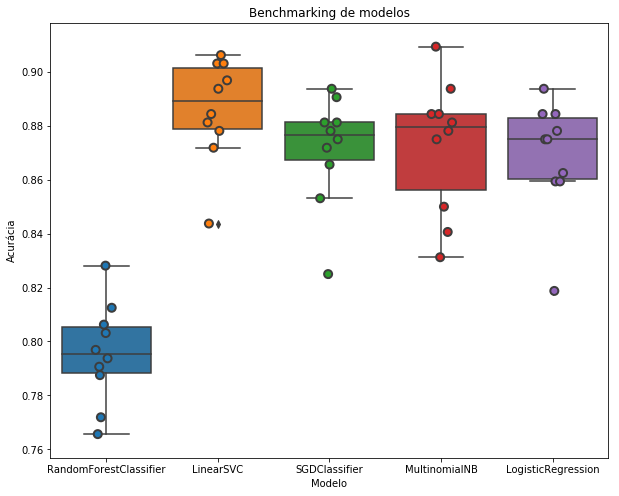

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    SGDClassifier(loss='hinge', penalty='l2',
                  alpha=1e-3, random_state=42,
                  max_iter=5, tol=None),
    MultinomialNB(alpha=.01),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fig = plt.figure(figsize=(10,8))
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Benchmarking de modelos')
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.show()

In [11]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.787500
1,RandomForestClassifier,1,0.803125
2,RandomForestClassifier,2,0.812500
3,RandomForestClassifier,3,0.828125
4,RandomForestClassifier,4,0.790625
5,RandomForestClassifier,5,0.793750
6,RandomForestClassifier,6,0.765625
7,RandomForestClassifier,7,0.806250
8,RandomForestClassifier,8,0.771875
9,RandomForestClassifier,9,0.796875


O benchmarking de modelos nos mostrou que nossa hipótese é bastante competitiva frente a outras alternativas, ainda que não conte com o desempenho mais consistente dentro da validação cruzada. Apesar disso, iremos continuar a construção de nosso modelo baseado no Naïve Bayees pois, conforme a literatura correlata afirma, apesar de o LinearSVC contar com um desempenho até mais consistente, a o desempenho computacional desta classe de algoritmos tende a cair a medida que a escala do problema aumenta (mais dados e/ou características). 

Logo, vamos continuar com nossa hipótese e realizar, ainda que de modo simples, o ajuste de alguns hiperparâmetros deste modelo, visando obter a melhor combinação possível para otimizarmos ainda mais o desempenho deste modelo.



In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    #plt.figure()
    fig = plt.figure(figsize=(10,8))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Amostras")
    plt.ylabel("Acurácia")
    plt.legend(loc="best")
    plt.grid(True) 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

clf_gs = GridSearchCV(MultinomialNB(), 
                   param_grid={
                       "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10.0],
                   })

print("Melhor combinação de parâmetros para o modelo: %s" % clf_gs.fit(X, y).best_params_)

Melhor combinação de parâmetros para o modelo: {'alpha': 0.01}


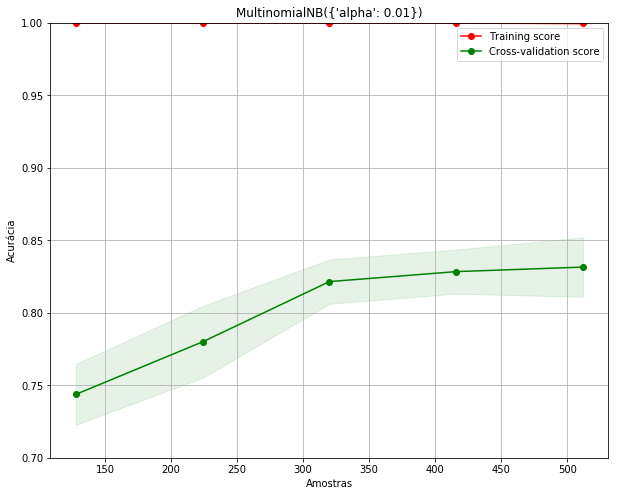

In [13]:
plot_learning_curve(clf_gs, "MultinomialNB({'alpha': 0.01})", X, y, ylim=(0.7, 1.0), train_sizes=np.linspace(.05, 0.2, 5))

Percebe-se que a curva de aprendizagem durante o ajuste automático dos parâmetros, considerando a validação cruzada, mostra um grau de overfitting no modelo NB, ainda que moderado (alta acurácia na fase de treino, menor acurácia na fase de teste). Ainda assim, parece razoável o desempenho do modelo para dados de teste, pois ~85% é um score aceitável, diante das características desta implementação.

Porém, em um pipeline de construção de modelo de machine learning, uma boa prática é não olhar apenas para uma métrica de desempenho. Por isso, agora vamos além da simples acurácia e olhar como o modelo classifica os dados de testes olhando para a matriz de confusão. Esta ferramenta possibilita avaliar o desempenho de classificação do modelo para cada classe de nosso conjunto de teste, muito útil para avaliar se há algum desequilíbrio no processo de previsão de classes.

Text(0.5,0,'Gênero Original')

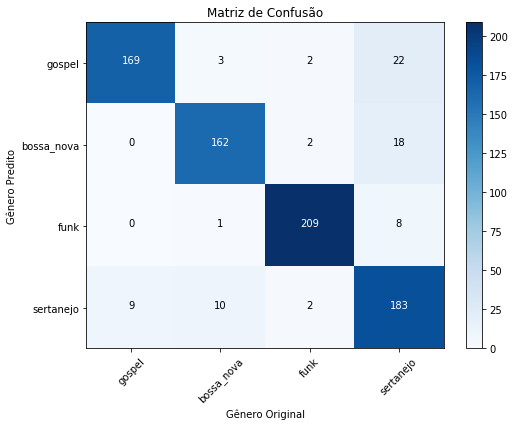

In [14]:
# Matriz de confusão
fig = plt.figure(figsize=(8,6))
cm = metrics.confusion_matrix(y_test, y_pred)
classes = list( df['genre'].unique() )
plt.imshow(cm, cmap=plt.cm.Blues, aspect='auto')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.title('Matriz de Confusão')
plt.ylabel('Gênero Predito')
plt.xlabel('Gênero Original')

A matriz de confusão mostra que estamos no caminho certo: nosso modelo possui bom desempenho de classificação para todos os gêneros musicais.

Podemos ir ainda mais a fundo na avaliação de nosso modelo: dada esta matriz de confusão, podemos calcular outras métricas como precisão, recall e f-score, que revelam outros aspectos de desempenho que são extremamente úteis na avaliação de um modelo de ml. Seguem uma breve descrição de cada uma destas métricas:

- <b>Precissão</b>: apesar de parecido com a acurácia, a Precisão se refere a habilidade do classificador de NÃO rotular uma amostra negativa como sendo positiva. Para ficar mais claro, em nosso contexto, é a habilidade de não classificar uma música 'funk' sendo que ela é do gênero 'bossa nova';

- <b>Recall</b>: mensura a habilidade do classificador de encontrar os verdadeiros-positivos, ou seja, de classificar uma música do gênero X como sendo de fato do Gênero X;

- <b>F-score</b>: é a média harmónica entre Precisão e Recall.

Para calcular estas métricas utilizaremos a função <i>precision_recall_fscore_support</i> distribuído em <i>sklearn.metrics</i>, conforme abaixo.


In [15]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
for n,genre in enumerate(list(df['genre'].unique())):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

GOSPEL_precision: 0.949438202247191
GOSPEL_recall: 0.8622448979591837
GOSPEL_fscore: 0.9037433155080214
GOSPEL_support: 196

BOSSA_NOVA_precision: 0.9204545454545454
BOSSA_NOVA_recall: 0.8901098901098901
BOSSA_NOVA_fscore: 0.9050279329608938
BOSSA_NOVA_support: 182

FUNK_precision: 0.9720930232558139
FUNK_recall: 0.9587155963302753
FUNK_fscore: 0.9653579676674365
FUNK_support: 218

SERTANEJO_precision: 0.7922077922077922
SERTANEJO_recall: 0.8970588235294118
SERTANEJO_fscore: 0.8413793103448276
SERTANEJO_support: 204



Antes de mais nada, o <b>Support</b> é o número de amostras de cada classe (verdadeiros positivos, ou VP). Vale notar que o split dos dados desbalanceou levemtente o conjunto de testes, mas em geral temos um equilíbrio que permite avaliar bem a permformance do modelo para a classifacação dentro de cada gênero musical.

Em linhas gerais, percebe-se um bom desempenho do modelo classificador em todos as métricas diante dos 4 gêneros musicais de nosso dataset. Porém, vale notar que apenas que a performance geral de nosso modelo cai um pouco diante de músicas sertanejas; analisando a matriz de confusão percebemos que nosso modelo confunde algumas músicas deste estilo com as dos gêneros 'gospel' e 'bossa nova' (classificando erroneamente 22 e 19 músicas como sendo destes gêneros, respectivamente). Uma hióptese para este comportamento pode ser visto no notebook 'data_analysis', o qual mostra que as letras de músicas sertanejas compartilham algumas palavras popularmente presentes em suas letras (como 'amor', 'tudo', 'vai', por exemplo) com estes dois gêneros.
Uma evolução neste sentido poderia ser feita inserindo mais músicas nos conjunto de dados, ou realizando o ajuste dos parâmetros do vetorizador, conforme já citado anteriormente.

Porém, diante de todo o contexto discutido até aqui, podemos considerar o modelo desenvolvido como sendo uma boa hipótese para a classificação de gêneros musicais a partir de letras. Assm, vamos exportar o modelo Naïve Bais calibrado para um arquivo pickle, a fim de que possamos implementar nossa solução web de classificação de gêneros musicais.

In [16]:
# Salvando o classificador (webapp)
with open('../resources/classifier.pkl', 'wb') as outfile:
    pickle.dump(clf, outfile, pickle.HIGHEST_PROTOCOL) 

## Conclusão
---
O modelo probabilístico de Naïve Bayes se mostra eficiente para a resolução do problema de classificação de gênero musical baseado em letras, com uma taxa de precisão de mais de 90% obtido pelo classificador proposto! Conforme os testes destacaram, corroborando a liteturatura correlata, o processo de preparação e tratamento dos dados possui grande influência no resultado final do modelo.<br>

Para a evolução do modelo, podemos discutir os seguintes tópicos:

* Uma vez que extraimos o vetor de palavras atravé do TFIDF, uma etapa potencialmente interessante para a melhoria do modelo seria a seleção de atributos mais significativos, uma vez que vários termos podem não ter valores TFIDF que não são preditivos e, no geral, acabam inserindo viés ou confusão no modelo. Além disso, com um menor espaço de característica, o desemepnho computacional poderia ser fortemente otimizado, dado que o processo de vetorização via TFIDF pode resultar em um problema de grande escala dimensional; 

* Avaliar modelos de machine learning mais complexos para este domínio de problema, realizando um benchmarking mais completo;

* A exploração adicional da preparação do conjunto de dados pode ser mais profundamente investigada. Por exemplo, seria interessante buscar padrões sintáticos que distinguem os gêneros; 

* Avaliar outras abordagens no processo de criação de tokens, considerando outros n-gramas ou aplicar redução do radical (stemização) aos termos do conjunto de dados. 

* Avaliação de novos modelos que relevem o contexto semântico das composições, tal como Word2Vec. 

Em linhas gerais, estas estratégias podem colaborar para melhorar ainda mais os resultados obtidos no problema de clâssificação de gênero musical baseado em letras.

## References

* https://arxiv.org/pdf/1611.00138.pdf
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* http://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* https://www.reddit.com/r/MachineLearning/comments/2q2185/improving_naive_bayes_accuracy_for_text/
* https://medium.com/@bored.analytics/predicting-genres-from-song-lyrics-aff6c9f956c0
* _
* https://www.vooo.pro/insights/6-passos-faceis-para-aprender-o-algoritmo-naive-bayes-com-o-codigo-em-python/
* https://www.ppgia.pucpr.br/~paraiso/mineracaodeemocoes/recursos/emocoesENIAC2013.pdf
* _
* https://www.serasaexperian.com.br/datalabs-noticias/padroes-em-sequencias-embeddings-e-word2vec/
* _
* https://spandan-madan.github.io/DeepLearningProject/
* http://radimrehurek.com/data_science_python/

In [17]:
%reload_ext watermark
%watermark -d -t -a "Autor: Diego Luiz Cavalca, em" -p sklearn,numpy,pandas,matplotlib,nltk,itertools,pickle -v -m

Autor: Diego Luiz Cavalca, em 2019-04-06 16:14:01 

CPython 3.6.5
IPython 6.4.0

sklearn 0.19.1
numpy 1.13.3
pandas 0.24.2
matplotlib 2.2.2
nltk 3.3
itertools unknown
pickle unknown

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
